# General models

Aim to create a range of underfitting, overfitting and fairly well optimised models based on bitcoin dataset.

These models will help give some indication of the effects of adding and removing parameters and hyperparameters and serve as a set of baseline models to work from when optimising each coin for the most effective sets of parameters found.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
dogecoin_csv = os.path.join(current_folder, "data","dogecoin_hourly.csv")
dogecoin_df = pd.read_csv(dogecoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
dogecoin_df['highLowDif'] = dogecoin_df['highPriceUsd'] - dogecoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
dogecoin_df['datetime'] = pd.to_datetime(dogecoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = dogecoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = dogecoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = dogecoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [7]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [8]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
Name: 0, dtype: object

In [9]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'dogecoin_polarity', 'dogecoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [10]:
timeperiod_df.iloc[0]

dogecoin_count                 7.570000e+02
dogecoin_polarity_zeros        9.003420e-02
dogecoin_subjectivity_zeros    2.761818e-01
closePriceUsd                  3.370579e-02
highPriceUsd                   3.370579e-02
lowPriceUsd                    3.139156e-02
volume                         2.941706e+09
Name: 0, dtype: float64

In [11]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples+validation_samples, 0)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples+validation_samples, 0)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 48      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 2160th, validation: 2160th, test: 2400th
Input shape: (128, 48, 7)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 3s 161ms/step - loss: 1.2170 - val_loss: 2.1863
Epoch 2/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0646 - val_loss: 2.3377
Epoch 3/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0889 - val_loss: 2.3576
Epoch 4/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0302 - val_loss: 2.6043
Epoch 5/20
13/13 [==============================] - 2s 149ms/step - loss: 0.0548 - val_loss: 2.5858
Epoch 6/20
13/13 [==============================] - 2s 145ms/step - loss: 0.0602 - val_loss: 2.5346
Epoch 7/20
13/13 [==============================] - 2s 148ms/step - loss: 0.0295 - val_loss: 2.5876
Epoch 8/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0271 - val_loss: 2.9814
Epoch 9/20
13/13 [==============================] - 2s 150ms/step - loss: 0.0778 - val_loss: 2.4520
Epoch 10/20
13/13 [==============================] - 2s 142ms/step - loss: 0.0144 - val_loss: 2.7554

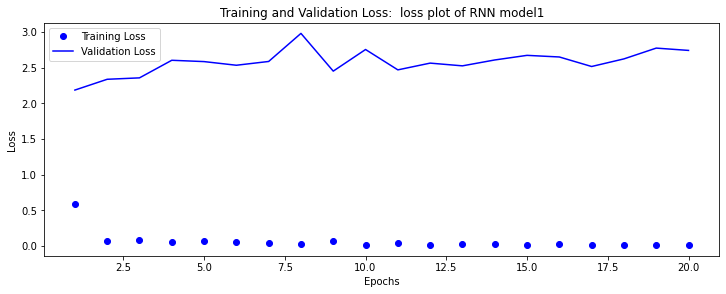

In [12]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 4s 174ms/step - loss: 0.6254 - val_loss: 2.5866
Epoch 2/20
13/13 [==============================] - 2s 162ms/step - loss: 0.1340 - val_loss: 2.7451
Epoch 3/20
13/13 [==============================] - 2s 154ms/step - loss: 0.0955 - val_loss: 3.5675
Epoch 4/20
13/13 [==============================] - 2s 168ms/step - loss: 0.0691 - val_loss: 3.0988
Epoch 5/20
13/13 [==============================] - 2s 173ms/step - loss: 0.0502 - val_loss: 3.6068
Epoch 6/20
13/13 [==============================] - 2s 162ms/step - loss: 0.0765 - val_loss: 4.0955
Epoch 7/20
13/13 [==============================] - 2s 163ms/step - loss: 0.0746 - val_loss: 4.3210
Epoch 8/20
13/13 [==============================] - 2s 163ms/step - loss: 0.0580 - val_loss: 3.8207
Epoch 9/20
13/13 [==============================] - 3s 230ms/step - loss: 0.0487 - val_loss: 3.6804
Epoch 10/20
13/13 [==============================] - 2s 174ms/step - loss: 0.0506 - val_loss: 4.4804

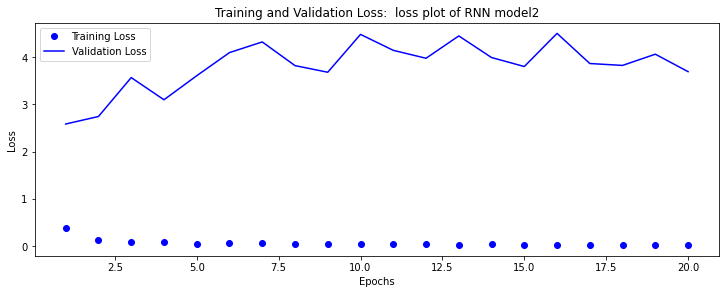

In [13]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 3s 150ms/step - loss: 0.4321 - val_loss: 3.3765
Epoch 2/30
13/13 [==============================] - 2s 136ms/step - loss: 0.0465 - val_loss: 3.4895
Epoch 3/30
13/13 [==============================] - 2s 165ms/step - loss: 0.0389 - val_loss: 3.4823
Epoch 4/30
13/13 [==============================] - 2s 128ms/step - loss: 0.0331 - val_loss: 3.4749
Epoch 5/30
13/13 [==============================] - 2s 131ms/step - loss: 0.0304 - val_loss: 3.5606
Epoch 6/30
13/13 [==============================] - 1s 115ms/step - loss: 0.0458 - val_loss: 3.4854
Epoch 7/30
13/13 [==============================] - 2s 129ms/step - loss: 0.0220 - val_loss: 3.2439
Epoch 8/30
13/13 [==============================] - 2s 121ms/step - loss: 0.0429 - val_loss: 3.2913
Epoch 9/30
13/13 [==============================] - 2s 129ms/step - loss: 0.0307 - val_loss: 3.5006
Epoch 10/30
13/13 [==============================] - 2s 131ms/step - loss: 0.0181 - val_loss: 3.2098

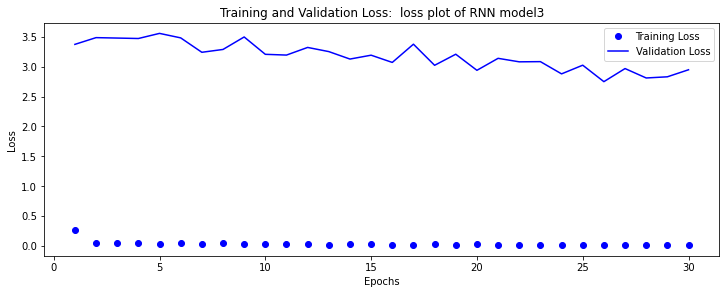

In [14]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 3s 155ms/step - loss: 0.4886 - val_loss: 2.3572
Epoch 2/30
13/13 [==============================] - 2s 144ms/step - loss: 0.1536 - val_loss: 2.9274
Epoch 3/30
13/13 [==============================] - 2s 144ms/step - loss: 0.1051 - val_loss: 3.1487
Epoch 4/30
13/13 [==============================] - 2s 165ms/step - loss: 0.0690 - val_loss: 4.0238
Epoch 5/30
13/13 [==============================] - 2s 151ms/step - loss: 0.0818 - val_loss: 3.8017
Epoch 6/30
13/13 [==============================] - 2s 143ms/step - loss: 0.0636 - val_loss: 4.3841
Epoch 7/30
13/13 [==============================] - 2s 134ms/step - loss: 0.0588 - val_loss: 4.5433
Epoch 8/30
13/13 [==============================] - 2s 169ms/step - loss: 0.0523 - val_loss: 4.1720
Epoch 9/30
13/13 [==============================] - 2s 134ms/step - loss: 0.0418 - val_loss: 4.1640
Epoch 10/30
13/13 [==============================] - 2s 144ms/step - loss: 0.0472 - val_loss: 4.2630

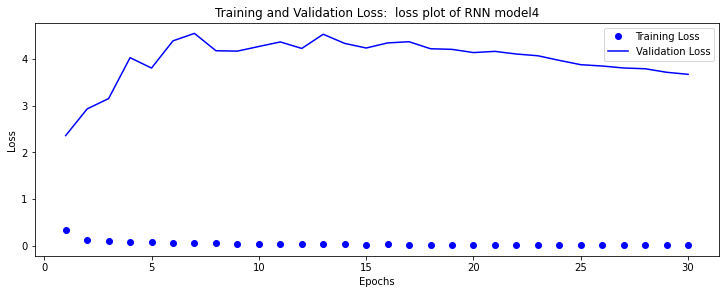

In [15]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 3s 137ms/step - loss: 0.3020 - val_loss: 2.3025
Epoch 2/30
13/13 [==============================] - 2s 119ms/step - loss: 0.0446 - val_loss: 2.4764
Epoch 3/30
13/13 [==============================] - 2s 121ms/step - loss: 0.0343 - val_loss: 2.5438
Epoch 4/30
13/13 [==============================] - 1s 106ms/step - loss: 0.0329 - val_loss: 2.5569
Epoch 5/30
13/13 [==============================] - 2s 138ms/step - loss: 0.0233 - val_loss: 2.5912
Epoch 6/30
13/13 [==============================] - 2s 155ms/step - loss: 0.0218 - val_loss: 2.5671
Epoch 7/30
13/13 [==============================] - 1s 111ms/step - loss: 0.0286 - val_loss: 2.4847
Epoch 8/30
13/13 [==============================] - 2s 164ms/step - loss: 0.0204 - val_loss: 2.5776
Epoch 9/30
13/13 [==============================] - 2s 118ms/step - loss: 0.0195 - val_loss: 2.5075
Epoch 10/30
13/13 [==============================] - 1s 117ms/step - loss: 0.0173 - val_loss: 2.5115

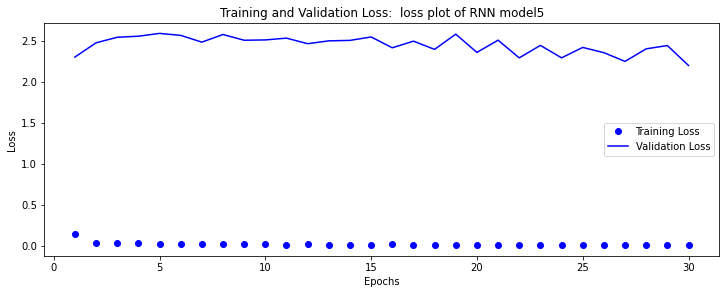

In [16]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 3s 143ms/step - loss: 0.7204 - val_loss: 3.0146
Epoch 2/30
13/13 [==============================] - 2s 129ms/step - loss: 0.1672 - val_loss: 3.1495
Epoch 3/30
13/13 [==============================] - 2s 128ms/step - loss: 0.1173 - val_loss: 2.9015
Epoch 4/30
13/13 [==============================] - 2s 129ms/step - loss: 0.0892 - val_loss: 3.0884
Epoch 5/30
13/13 [==============================] - 2s 124ms/step - loss: 0.0616 - val_loss: 3.3667
Epoch 6/30
13/13 [==============================] - 2s 127ms/step - loss: 0.0625 - val_loss: 3.4055
Epoch 7/30
13/13 [==============================] - 2s 122ms/step - loss: 0.0421 - val_loss: 3.3613
Epoch 8/30
13/13 [==============================] - 2s 160ms/step - loss: 0.0527 - val_loss: 3.2612
Epoch 9/30
13/13 [==============================] - 2s 163ms/step - loss: 0.0386 - val_loss: 3.7242
Epoch 10/30
13/13 [==============================] - 2s 124ms/step - loss: 0.0419 - val_loss: 3.7933

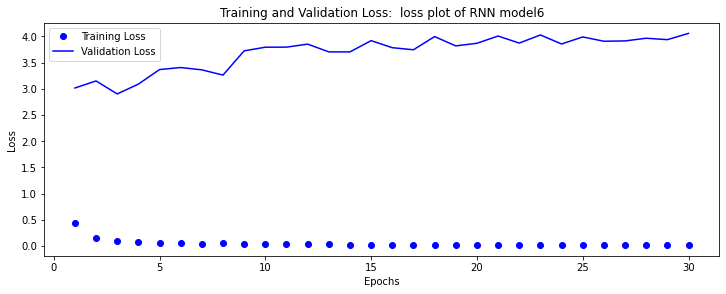

In [17]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 3s 116ms/step - loss: 0.1217 - val_loss: 3.6409
Epoch 2/40
13/13 [==============================] - 1s 108ms/step - loss: 0.0382 - val_loss: 3.7485
Epoch 3/40
13/13 [==============================] - 1s 107ms/step - loss: 0.0284 - val_loss: 3.7957
Epoch 4/40
13/13 [==============================] - 1s 101ms/step - loss: 0.0232 - val_loss: 3.7951
Epoch 5/40
13/13 [==============================] - 1s 108ms/step - loss: 0.0199 - val_loss: 3.7807
Epoch 6/40
13/13 [==============================] - 1s 109ms/step - loss: 0.0176 - val_loss: 3.7432
Epoch 7/40
13/13 [==============================] - 1s 89ms/step - loss: 0.0162 - val_loss: 3.6775
Epoch 8/40
13/13 [==============================] - 1s 107ms/step - loss: 0.0155 - val_loss: 3.5913
Epoch 9/40
13/13 [==============================] - 1s 110ms/step - loss: 0.0133 - val_loss: 3.5536
Epoch 10/40
13/13 [==============================] - 2s 126ms/step - loss: 0.0168 - val_loss: 3.4244


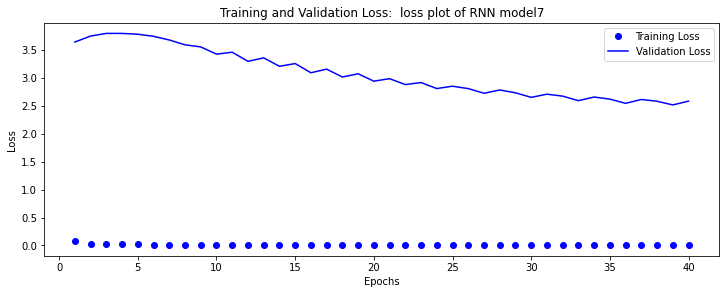

In [18]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 3s 128ms/step - loss: 0.3601 - val_loss: 2.3855
Epoch 2/30
13/13 [==============================] - 1s 106ms/step - loss: 0.1134 - val_loss: 3.2672
Epoch 3/30
13/13 [==============================] - 2s 119ms/step - loss: 0.0692 - val_loss: 3.6209
Epoch 4/30
13/13 [==============================] - 1s 113ms/step - loss: 0.0445 - val_loss: 3.7353
Epoch 5/30
13/13 [==============================] - 1s 117ms/step - loss: 0.0390 - val_loss: 3.9087
Epoch 6/30
13/13 [==============================] - 1s 116ms/step - loss: 0.0291 - val_loss: 3.8972
Epoch 7/30
13/13 [==============================] - 1s 100ms/step - loss: 0.0237 - val_loss: 3.7244
Epoch 8/30
13/13 [==============================] - 1s 106ms/step - loss: 0.0190 - val_loss: 3.7111
Epoch 9/30
13/13 [==============================] - 1s 108ms/step - loss: 0.0168 - val_loss: 3.6989
Epoch 10/30
13/13 [==============================] - 1s 100ms/step - loss: 0.0149 - val_loss: 3.7033

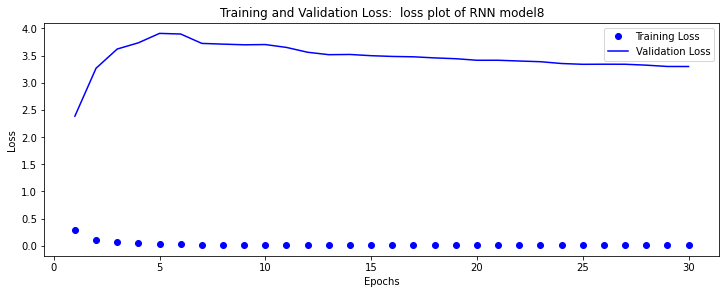

In [19]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 3s 127ms/step - loss: 0.5059 - val_loss: 4.3711
Epoch 2/20
13/13 [==============================] - 1s 91ms/step - loss: 0.0576 - val_loss: 4.3085
Epoch 3/20
13/13 [==============================] - 1s 110ms/step - loss: 0.0344 - val_loss: 4.2275
Epoch 4/20
13/13 [==============================] - 1s 111ms/step - loss: 0.0218 - val_loss: 4.2130
Epoch 5/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0169 - val_loss: 4.1824
Epoch 6/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0145 - val_loss: 4.1127
Epoch 7/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0128 - val_loss: 4.0165
Epoch 8/20
13/13 [==============================] - 1s 107ms/step - loss: 0.0117 - val_loss: 3.9160
Epoch 9/20
13/13 [==============================] - 1s 111ms/step - loss: 0.0108 - val_loss: 3.8231
Epoch 10/20
13/13 [==============================] - 1s 112ms/step - loss: 0.0101 - val_loss: 3.7399


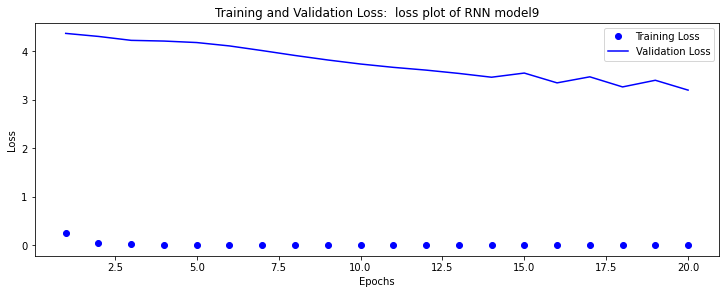

In [20]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 3s 120ms/step - loss: 0.5575 - val_loss: 3.8077
Epoch 2/20
13/13 [==============================] - 1s 116ms/step - loss: 0.1643 - val_loss: 3.6126
Epoch 3/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0809 - val_loss: 3.5195
Epoch 4/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0425 - val_loss: 3.5313
Epoch 5/20
13/13 [==============================] - 2s 124ms/step - loss: 0.0319 - val_loss: 3.5223
Epoch 6/20
13/13 [==============================] - 1s 104ms/step - loss: 0.0217 - val_loss: 3.5522
Epoch 7/20
13/13 [==============================] - 1s 104ms/step - loss: 0.0177 - val_loss: 3.4726
Epoch 8/20
13/13 [==============================] - 1s 114ms/step - loss: 0.0135 - val_loss: 3.4417
Epoch 9/20
13/13 [==============================] - 1s 117ms/step - loss: 0.0133 - val_loss: 3.3916
Epoch 10/20
13/13 [==============================] - 2s 119ms/step - loss: 0.0124 - val_loss: 3.3543

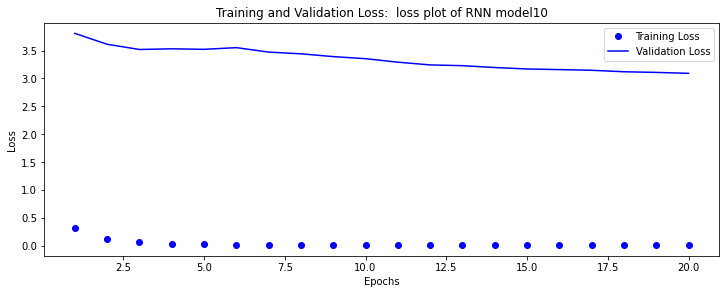

In [21]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 3s 117ms/step - loss: 0.3580 - val_loss: 2.7871
Epoch 2/40
13/13 [==============================] - 2s 176ms/step - loss: 0.1983 - val_loss: 2.9731
Epoch 3/40
13/13 [==============================] - 1s 99ms/step - loss: 0.1310 - val_loss: 3.0935
Epoch 4/40
13/13 [==============================] - 2s 160ms/step - loss: 0.1018 - val_loss: 3.1597
Epoch 5/40
13/13 [==============================] - 1s 111ms/step - loss: 0.0636 - val_loss: 3.1793
Epoch 6/40
13/13 [==============================] - 1s 96ms/step - loss: 0.0513 - val_loss: 3.1742
Epoch 7/40
13/13 [==============================] - 1s 114ms/step - loss: 0.0393 - val_loss: 3.1846
Epoch 8/40
13/13 [==============================] - 1s 111ms/step - loss: 0.0328 - val_loss: 3.1667
Epoch 9/40
13/13 [==============================] - 1s 114ms/step - loss: 0.0221 - val_loss: 3.1845
Epoch 10/40
13/13 [==============================] - 1s 107ms/step - loss: 0.0192 - val_loss: 3.1854
E

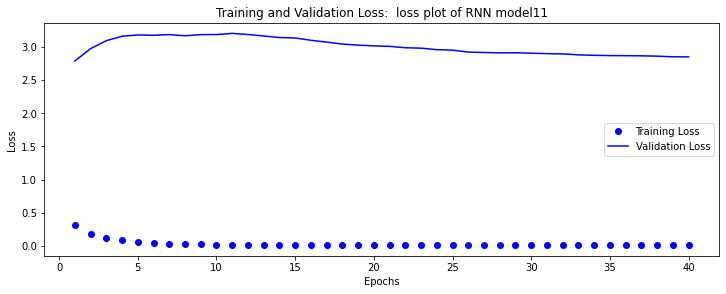

In [22]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 4s 164ms/step - loss: 0.5588 - val_loss: 3.0463
Epoch 2/30
13/13 [==============================] - 2s 139ms/step - loss: 0.2004 - val_loss: 4.3972
Epoch 3/30
13/13 [==============================] - 2s 146ms/step - loss: 0.1186 - val_loss: 4.3563
Epoch 4/30
13/13 [==============================] - 2s 146ms/step - loss: 0.0954 - val_loss: 4.3175
Epoch 5/30
13/13 [==============================] - 2s 143ms/step - loss: 0.0725 - val_loss: 5.0253
Epoch 6/30
13/13 [==============================] - 2s 144ms/step - loss: 0.0717 - val_loss: 4.7590
Epoch 7/30
13/13 [==============================] - 2s 139ms/step - loss: 0.0508 - val_loss: 4.4389
Epoch 8/30
13/13 [==============================] - 2s 143ms/step - loss: 0.0453 - val_loss: 4.4528
Epoch 9/30
13/13 [==============================] - 2s 140ms/step - loss: 0.0400 - val_loss: 4.4651
Epoch 10/30
13/13 [==============================] - 2s 136ms/step - loss: 0.0545 - val_loss: 4.5614

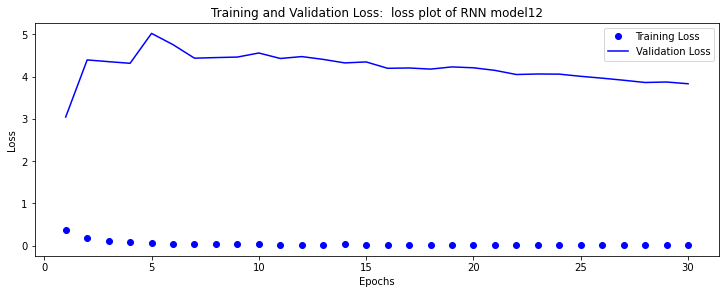

In [23]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 5s 201ms/step - loss: 0.4608 - val_loss: 4.6294
Epoch 2/30
13/13 [==============================] - 2s 172ms/step - loss: 0.0855 - val_loss: 4.8903
Epoch 3/30
13/13 [==============================] - 2s 185ms/step - loss: 0.0654 - val_loss: 4.6003
Epoch 4/30
13/13 [==============================] - 2s 166ms/step - loss: 0.0501 - val_loss: 4.3166
Epoch 5/30
13/13 [==============================] - 2s 160ms/step - loss: 0.0397 - val_loss: 4.2111
Epoch 6/30
13/13 [==============================] - 2s 160ms/step - loss: 0.0317 - val_loss: 4.1668
Epoch 7/30
13/13 [==============================] - 2s 170ms/step - loss: 0.0304 - val_loss: 4.1688
Epoch 8/30
13/13 [==============================] - 2s 172ms/step - loss: 0.0257 - val_loss: 4.0603
Epoch 9/30
13/13 [==============================] - 2s 170ms/step - loss: 0.0257 - val_loss: 4.0949
Epoch 10/30
13/13 [==============================] - 2s 165ms/step - loss: 0.0239 - val_loss: 4.1177

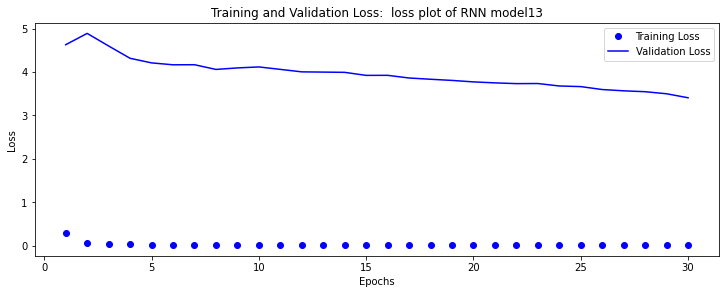

In [24]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 3s 119ms/step - loss: 0.3448 - val_loss: 2.2020
Epoch 2/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0937 - val_loss: 1.8089
Epoch 3/20
13/13 [==============================] - 1s 114ms/step - loss: 0.0502 - val_loss: 1.7333
Epoch 4/20
13/13 [==============================] - 1s 117ms/step - loss: 0.0392 - val_loss: 1.7371
Epoch 5/20
13/13 [==============================] - 1s 116ms/step - loss: 0.0324 - val_loss: 1.7443
Epoch 6/20
13/13 [==============================] - 1s 116ms/step - loss: 0.0330 - val_loss: 1.7534
Epoch 7/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0244 - val_loss: 1.7577
Epoch 8/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0278 - val_loss: 1.7920
Epoch 9/20
13/13 [==============================] - 1s 114ms/step - loss: 0.0196 - val_loss: 1.7331
Epoch 10/20
13/13 [==============================] - 2s 138ms/step - loss: 0.0282 - val_loss: 1.7478

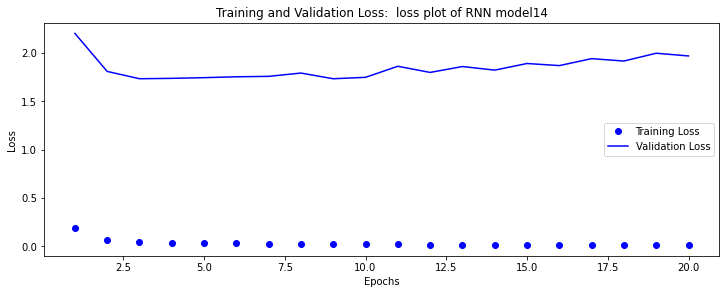

In [25]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 3s 180ms/step - loss: 0.8221 - val_loss: 3.5656
Epoch 2/20
13/13 [==============================] - 1s 108ms/step - loss: 0.3015 - val_loss: 3.3263
Epoch 3/20
13/13 [==============================] - 1s 107ms/step - loss: 0.1511 - val_loss: 3.2900
Epoch 4/20
13/13 [==============================] - 2s 146ms/step - loss: 0.0792 - val_loss: 3.3026
Epoch 5/20
13/13 [==============================] - 1s 88ms/step - loss: 0.0442 - val_loss: 3.3514
Epoch 6/20
13/13 [==============================] - 2s 147ms/step - loss: 0.0305 - val_loss: 3.3729
Epoch 7/20
13/13 [==============================] - 1s 108ms/step - loss: 0.0238 - val_loss: 3.3498
Epoch 8/20
13/13 [==============================] - 1s 112ms/step - loss: 0.0193 - val_loss: 3.2938
Epoch 9/20
13/13 [==============================] - 1s 92ms/step - loss: 0.0162 - val_loss: 3.2203
Epoch 10/20
13/13 [==============================] - 1s 110ms/step - loss: 0.0142 - val_loss: 3.1545
E

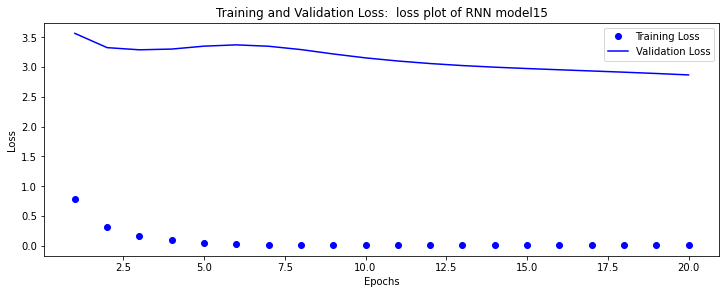

In [26]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 3s 123ms/step - loss: 0.7574 - val_loss: 5.3820
Epoch 2/20
13/13 [==============================] - 1s 106ms/step - loss: 0.0851 - val_loss: 5.4244
Epoch 3/20
13/13 [==============================] - 2s 119ms/step - loss: 0.0687 - val_loss: 5.1284
Epoch 4/20
13/13 [==============================] - 2s 123ms/step - loss: 0.0699 - val_loss: 4.8961
Epoch 5/20
13/13 [==============================] - 2s 117ms/step - loss: 0.0533 - val_loss: 4.7285
Epoch 6/20
13/13 [==============================] - 2s 180ms/step - loss: 0.0525 - val_loss: 4.5570
Epoch 7/20
13/13 [==============================] - 2s 148ms/step - loss: 0.0398 - val_loss: 4.4377
Epoch 8/20
13/13 [==============================] - 2s 131ms/step - loss: 0.0393 - val_loss: 4.2195
Epoch 9/20
13/13 [==============================] - 2s 160ms/step - loss: 0.0299 - val_loss: 4.1282
Epoch 10/20
13/13 [==============================] - 2s 121ms/step - loss: 0.0304 - val_loss: 3.8788

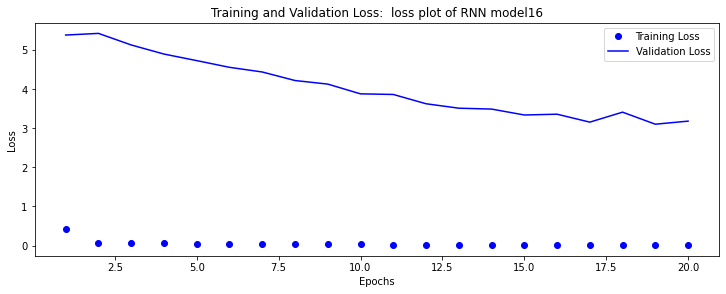

In [27]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 4s 160ms/step - loss: 0.3844 - val_loss: 4.8659
Epoch 2/20
13/13 [==============================] - 2s 131ms/step - loss: 0.0498 - val_loss: 4.4600
Epoch 3/20
13/13 [==============================] - 2s 125ms/step - loss: 0.0353 - val_loss: 4.5480
Epoch 4/20
13/13 [==============================] - 2s 124ms/step - loss: 0.0291 - val_loss: 4.6242
Epoch 5/20
13/13 [==============================] - 2s 127ms/step - loss: 0.0389 - val_loss: 4.6157
Epoch 6/20
13/13 [==============================] - 2s 129ms/step - loss: 0.0326 - val_loss: 4.4450
Epoch 7/20
13/13 [==============================] - 2s 129ms/step - loss: 0.0184 - val_loss: 4.5259
Epoch 8/20
13/13 [==============================] - 2s 126ms/step - loss: 0.0172 - val_loss: 4.3639
Epoch 9/20
13/13 [==============================] - 2s 129ms/step - loss: 0.0177 - val_loss: 4.3296
Epoch 10/20
13/13 [==============================] - 2s 120ms/step - loss: 0.0155 - val_loss: 4.5468

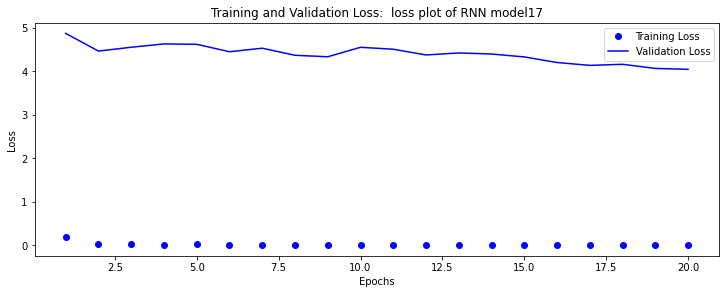

In [28]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 3s 141ms/step - loss: 0.3863 - val_loss: 3.1915
Epoch 2/20
13/13 [==============================] - 1s 117ms/step - loss: 0.1209 - val_loss: 3.3239
Epoch 3/20
13/13 [==============================] - 2s 118ms/step - loss: 0.0705 - val_loss: 3.5182
Epoch 4/20
13/13 [==============================] - 2s 143ms/step - loss: 0.0540 - val_loss: 3.5647
Epoch 5/20
13/13 [==============================] - 1s 116ms/step - loss: 0.0452 - val_loss: 3.5756
Epoch 6/20
13/13 [==============================] - 2s 127ms/step - loss: 0.0349 - val_loss: 3.5890
Epoch 7/20
13/13 [==============================] - 2s 117ms/step - loss: 0.0313 - val_loss: 3.5811
Epoch 8/20
13/13 [==============================] - 1s 103ms/step - loss: 0.0236 - val_loss: 3.5894
Epoch 9/20
13/13 [==============================] - 2s 156ms/step - loss: 0.0295 - val_loss: 3.5228
Epoch 10/20
13/13 [==============================] - 2s 143ms/step - loss: 0.0175 - val_loss: 3.5668

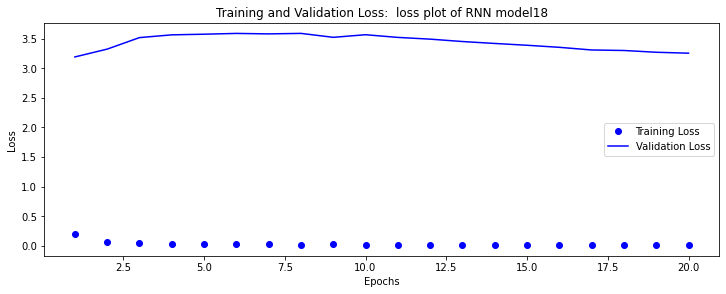

In [29]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [31]:
histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 2.186340808868408, epoch: 1
Model 2: min val loss: 2.5865890979766846, epoch: 1
Model 3: min val loss: 2.7515270709991455, epoch: 26
Model 4: min val loss: 2.357171058654785, epoch: 1
Model 5: min val loss: 2.19968843460083, epoch: 30
Model 6: min val loss: 2.901467800140381, epoch: 3
Model 7: min val loss: 2.5153656005859375, epoch: 39
Model 8: min val loss: 2.3855319023132324, epoch: 1
Model 9: min val loss: 3.202019691467285, epoch: 20
Model 10: min val loss: 3.091935634613037, epoch: 20
Model 11: min val loss: 2.7871415615081787, epoch: 1
Model 12: min val loss: 3.046266794204712, epoch: 1
Model 13: min val loss: 3.4075543880462646, epoch: 30
Model 14: min val loss: 1.733117699623108, epoch: 9
Model 15: min val loss: 2.8686275482177734, epoch: 20
Model 16: min val loss: 3.1029140949249268, epoch: 19
Model 17: min val loss: 4.041632652282715, epoch: 20
Model 18: min val loss: 3.191465377807617, epoch: 1
